# Séries temporais com ARIMA e SARIMAX

## Importações e configurações iniciais

In [1]:
## Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Estilos para os gráficos
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

## Preparação dos dados

In [3]:
# definindo caminho do arquivo
PATH = "data/df_20181s_20201s_A523.csv"

# escolhendo target
TARGET = "UMD_INS"

# definindo coluna de data
DATE_COLUMN = "date"

# Carregamento dos dados
df = pd.read_csv(PATH)

# Convertendo datas
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])

# Selecionando colunas
df = df[[DATE_COLUMN, TARGET]]

# Preenchendo nulos com a média
df = df.fillna(method="ffill")

# Escolha da granularidade (diária)
df = df[[DATE_COLUMN,TARGET]].groupby(DATE_COLUMN).mean()

# Renomeando coluna TARGET
df.columns = ['Y_t']

# normalizando
df['X_t'] = StandardScaler().fit_transform(df['Y_t'].values.reshape(-1, 1))

## EDA

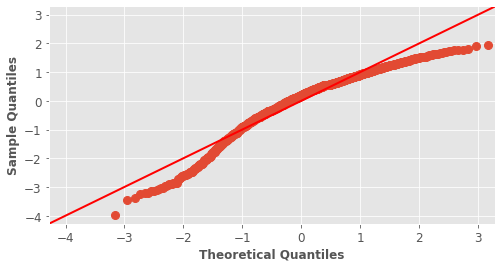

In [31]:
# qqplot de X_t
sm.qqplot(df['X_t'], line='45')
plt.show()

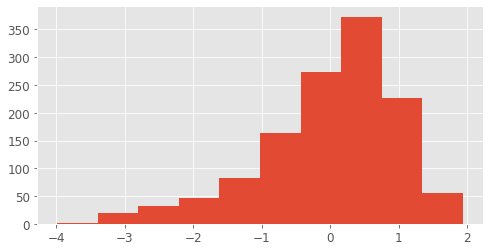

In [32]:
# histograma de X_T
df['X_t'].hist()
plt.show()

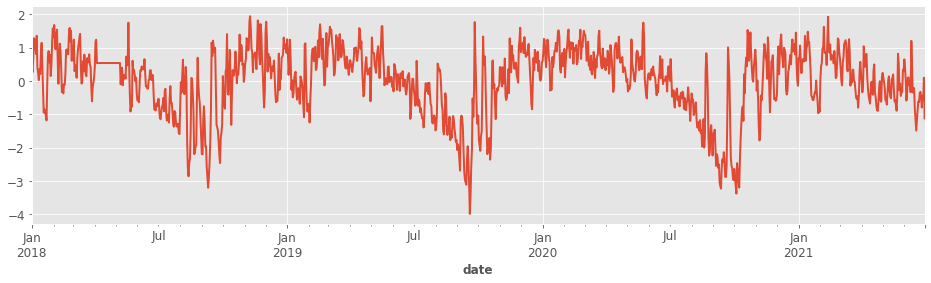

In [34]:
# X_t
df.X_t.plot(figsize=(16,4))
plt.show()

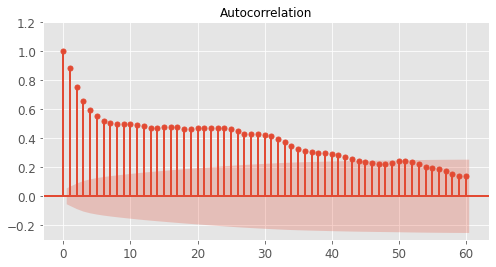

In [35]:
# Autocorrelação de X_t
sm.graphics.tsa.plot_acf(df['X_t'].values.squeeze(), lags=60)
plt.ylim(-0.3,1.2)
plt.show()

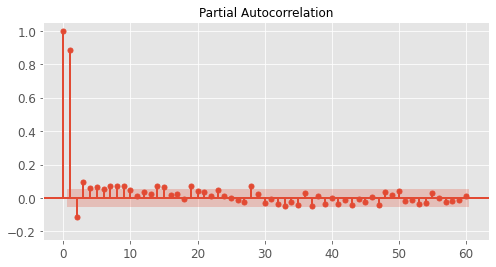

In [36]:
# Autocorrelação parcial de X_t
sm.graphics.tsa.plot_pacf(
    df['X_t'].values.squeeze(), 
    lags=60,
    method='ywm'
)
plt.ylim(-0.25, 1.05)
plt.show()

## Modelagem com ARIMA

In [45]:
# ARIMA(3, 1, 3)

# Dividindo conjuntos de treino e teste
train = df.X_t[:1096] # 01-01-2018 até 31-12-2020
test = df.X_t[1096:] # 01-01-2021 até 30-06-2021

# Ajustando parâmetros no conjunto de treino
train_arima313 = ARIMA(train, freq="D", order=(3,1,3)).fit()
train_arima313.params

ar.L1     0.450704
ar.L2     0.387416
ar.L3    -0.250959
ma.L1    -0.467880
ma.L2    -0.614673
ma.L3     0.189432
sigma2    0.217584
dtype: float64

In [46]:
# Calculando predições
test_arima313 = ARIMA(test, freq="D", order=(3,1,3)).fit(train_arima313.params)

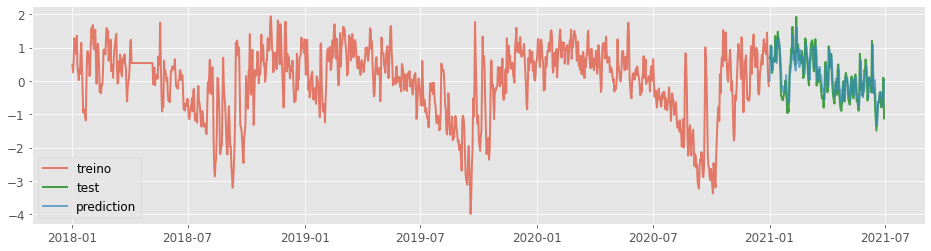

In [52]:
# Visualizando modelagem
pred = test_arima313.predict()
plt.figure(figsize=(16,4))
plt.plot(train.index, train, alpha=0.7, label="treino")
plt.plot(test.index, test, alpha=0.7, color="g", label="test")
plt.plot(pred.index, pred, alpha=0.7, label="prediction")
plt.legend()
plt.show()

In [53]:
# Avaliando o modelo com evs
explained_variance_score(test, pred)

0.640103171182913

## Modelagem com SARIMAX

In [54]:
# SARIMAX(3, 1, 3)(3,1,3,4)

# Dividindo conjuntos de treino e teste
train = df.X_t[:1096] # 01-01-2018 até 31-12-2020
test = df.X_t[1096:] # 01-01-2021 até 30-06-2021

# Ajustando parâmetros no conjunto de treino
train_sarimax313_31314 = SARIMAX(
    train, freq="D", order=(3,1,3), seasonal_order=(3,1,3,4)).fit()
train_sarimax313_31314.params

ar.L1       0.295144
ar.L2       0.557452
ar.L3      -0.316249
ma.L1      -0.326079
ma.L2      -0.780539
ma.L3       0.221039
ar.S.L4    -1.638749
ar.S.L8    -0.852928
ar.S.L12    0.001803
ma.S.L4     0.671544
ma.S.L8    -0.782423
ma.S.L12   -0.888398
sigma2      0.217745
dtype: float64

In [56]:
# Calculando predições
test_sarimax313_31314 = SARIMAX(
    test, freq="D",order=(3,1,3), seasonal_order=(3,1,3,4)).fit(train_sarimax313_31314.params)

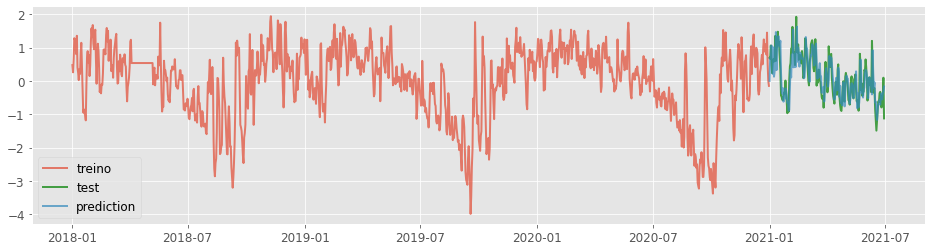

In [57]:
# Visualizando modelagem
pred = test_sarimax313_31314.predict()
plt.figure(figsize=(16,4))
plt.plot(train.index, train, alpha=0.7, label="treino")
plt.plot(test.index, test, alpha=0.7, color="g", label="test")
plt.plot(pred.index, pred, alpha=0.7, label="prediction")
plt.legend()
plt.show()

In [58]:
# Avaliando o modelo com evs
explained_variance_score(test, pred)

0.61847864528183

## Pipeline completo

In [59]:
def prepar_dataframe(path, target, date_column):
    df = pd.read_csv(path)
    df[date_column] = pd.to_datetime(df[date_column])
    df = df[[date_column, target]]
    df = df.fillna(method="ffill")
    df = df[[date_column,target]].groupby(date_column).mean()
    df.columns = ['Y_t']
    df['X_t'] = StandardScaler().fit_transform(df['Y_t'].values.reshape(-1, 1))
    return df

def arima_evs(df, arima_order, train_size):
    train = df.X_t[:train_size]
    test = df.X_t[train_size:]
    train_model = ARIMA(train, freq="D", order=arima_order).fit()
    test_model = ARIMA(test, freq="D", order=arima_order).fit(train_model.params)
    pred_test = test_model.predict()
    evs = explained_variance_score(test, pred_test)
    return evs

def sarimax_evs(df, arima_order, s_order, train_size):
    train = df.X_t[:train_size]
    test = df.X_t[train_size:]
    train_model = SARIMAX(train, freq="D", order=arima_order, seasonal_order=s_order).fit()
    test_model = SARIMAX(
        test, freq="D", order=arima_order, seasonal_order=s_order).fit(train_model.params)
    pred_test = test_model.predict()
    evs = explained_variance_score(test, pred_test)
    return evs

### Preparação dos dados

In [60]:
PATH = "data/df_20181s_20201s_A523.csv"
TARGET = "UMD_INS"
DATE_COLUMN = "date"
prepared_df = prepar_dataframe(PATH, TARGET, DATE_COLUMN)

### ARIMA

In [61]:
ARIMA_ORDER = (3,1,3)
TRAIN_SIZE = 1096
arima_evs(prepared_df, ARIMA_ORDER, TRAIN_SIZE)

0.640103171182913

### SARIMAX

In [62]:
ARIMA_ORDER = (3,1,3)
SARIMAX_ORDER = (3,1,3,4)
TRAIN_SIZE = 1096
sarimax_evs(prepared_df, ARIMA_ORDER, SARIMAX_ORDER, TRAIN_SIZE)

0.61847864528183

### Comparação entre ARIMA's

In [64]:
AR_params = []
I_params = []
MA_params = []
evs = []

for i in range(0,4):
    for j in range(0,4):
        for k in range(0,4):
            ARIMA_ORDER = (i,j,k)
            try:
                score = arima_evs(
                    prepared_df, ARIMA_ORDER, TRAIN_SIZE)
                evs.append(score)
                AR_params.append(i)
                I_params.append(j)
                MA_params.append(k)
            except:
                continue
            
df_results = pd.DataFrame({
    "AR_param": AR_params,
    "I_param": I_params,
    "MA_param": MA_params,
    "evs": evs
})

In [65]:
df_results.sort_values("evs", ascending=False)

,AR_param,I_param,MA_param,evs
51,3,0,3,0.646145
39,2,1,3,0.645151
54,3,1,2,0.642495
55,3,1,3,0.640103
35,2,0,3,0.635633
...,...,...,...,...
60,3,3,0,0.071578
0,0,0,0,0.000000
44,2,3,0,-0.166155
28,1,3,0,-0.492142


## Referências

Tutoriais:
- https://www.youtube.com/watch?v=pxd4ZzROqtI&list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-
- https://www.youtube.com/watch?v=JuGUAvC5qs8&list=PLSDVadsSlXTCVcg95hQsEOVRnVwgaPTRC

Bibliotecas:
- https://www.statsmodels.org/
- https://scikit-learn.org/
- https://pandas.pydata.org/
- https://matplotlib.org/

Dados:
- https://tempo.inmet.gov.br/